In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler 
from sklearn import model_selection
from surprise import Dataset, Reader, accuracy, KNNBasic, SVD, NMF, SlopeOne, CoClustering, BaselineOnly
from surprise.model_selection import cross_validate

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)


In [ ]:
df = pd.read_csv('Ecommerce_Data2.csv')

In [ ]:
df = df.drop('Unnamed: 0',axis=1)

In [ ]:
df['date'] = df['event_time'].apply(lambda x: x.split()[0])
df['date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df = df[df['date']<pd.Timestamp('2019-10-6 00:00:00')]
df.to_csv('initialdf.csv')
df

In [ ]:
df['user_score'] = df['event_type'].map({'view':1,'cart':10,'purchase':50})
df['user_purchase'] = df['event_type'].apply(lambda x: 1 if x=='purchase' else 0)
df['price_category'] = 0
for i in df['category_code'].unique():
    df.loc[df['category_code']==i,'price_category'] = pd.qcut(x=df['price'][df['category_code']==i],q=5,labels=[1,2,3,4,5])
df    

In [ ]:
df.to_csv('initialdf1.csv')

In [ ]:
for i in df['category_code'].unique():
    df.loc[df['category_code']==i,'price_category'] = pd.qcut(x=df['price'][df['category_code']==i],q=5,labels=[1,2,3,4,5])

In [ ]:
group = df.groupby(['user_id','product_id'])['user_score','user_purchase'].sum().reset_index()
group['user_purchase'] = group['user_purchase'].apply(lambda x: 1 if x>1 else x)
group['user_score'] = group['user_score'].apply(lambda x: 100 if x>100 else x)

In [ ]:
std = MinMaxScaler(feature_range=(0.025, 1))
std.fit(group['user_score'].values.reshape(-1,1))
group['interaction_score'] = std.transform(group['user_score'].values.reshape(-1,1))

In [ ]:
group = group.merge(df[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on=['product_id'])

In [ ]:
X_train_val, X_test = model_selection.train_test_split(group,test_size=0.2, random_state=42)

In [ ]:
X_train, X_valid = model_selection.train_test_split(X_train_val,test_size=0.16, random_state=42)

In [ ]:
X_valid1 = X_valid.copy()
X_valid2 = X_valid.copy()
X_train_val1 = X_train_val.copy()

In [ ]:
product_cat = X_train[['product_id','price_category','category_code']].drop_duplicates('product_id')
product_cat = product_cat.sort_values(by='product_id')
product_cat

In [ ]:
product_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1))+1)

In [ ]:
euclidean_matrix = pd.DataFrame(product_cat_matrix,columns=product_cat['product_id'],index=product_cat['product_id'])

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
dt_matrix = pd.DataFrame(doc_term.toarray().round(3), index=[i for i in product_cat['product_id']], columns=tfidf_vectorizer.get_feature_names())

In [ ]:
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix.values),columns=product_cat['product_id'],index=product_cat['product_id'])

In [ ]:
similar_matrix = cos_similar_matrix.multiply(euclidean_matrix)

In [ ]:
X_train_matrix = pd.pivot_table(X_train,values='user_score',index='user_id',columns='product_id')
X_train_matrix = X_train_matrix.fillna(0)

In [ ]:
content_matrix = np.matmul(X_train_matrix, similar_matrix)
scaler = MinMaxScaler(feature_range=(0, 1))
content_matrix_scaled = scaler.fit_transform(content_matrix)
content_df = pd.DataFrame(content_matrix_scaled, columns=sorted(X_train['product_id'].unique()), index=sorted(X_train['user_id'].unique())).stack().reset_index()
content_df = content_df.rename(columns={'level_0': 'user_id', 'level_1': 'product_id', 0: 'predicted_interaction'})
X_valid = pd.merge(X_valid, content_df, on=['user_id', 'product_id'])

In [ ]:
threshold = 0.5
X_valid['predicted_purchase'] = (X_valid['predicted_interaction'] >= threshold).astype(int)


In [ ]:
item_price_precision = precision_score(X_valid['user_purchase'], X_valid['predicted_purchase'], average='binary')
item_price_precision


In [ ]:
item_price_recall = recall_score(X_valid['user_purchase'], X_valid['predicted_purchase'], average='binary')
item_price_recall


In [ ]:
item_price_f1 = f1_score(X_valid['user_purchase'], X_valid['predicted_purchase'], average='binary')
item_price_f1


In [ ]:
content_matrix = np.matmul(X_train_matrix, cos_similar_matrix)
scaler = MinMaxScaler(feature_range=(0, 1))
content_matrix_scaled = scaler.fit_transform(content_matrix)
content_df = pd.DataFrame(content_matrix_scaled, columns=sorted(X_train['product_id'].unique()), index=sorted(X_train['user_id'].unique())).stack().reset_index()
content_df = content_df.rename(columns={'level_0': 'user_id', 'level_1': 'product_id', 0: 'predicted_interaction'})
X_valid1 = X_valid1.merge(content_df, on=['user_id', 'product_id'])


In [ ]:
X_valid1['predicted_purchase'] = X_valid1['predicted_interaction'].apply(lambda x:1 if x>=0.5 else 0)

In [ ]:
item_precision = precision_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_precision

In [ ]:
item_recall = recall_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_recall

In [ ]:
item_f1 = f1_score(X_valid1['user_purchase'],X_valid1['predicted_purchase'])
item_f1

In [ ]:

import pandas as pd

product_cat = pd.DataFrame({
    'product_id': X_train['product_id'],
    'price_category': X_train['price_category'],
    'category_code': X_train['category_code'],
    'brand': X_train['brand']
})

product_cat.drop_duplicates(subset='product_id', inplace=True)

product_cat.sort_values(by='product_id', inplace=True)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidf_vectorizer = TfidfVectorizer()

doc_term = tfidf_vectorizer.fit_transform(product_cat['brand'].tolist())

dt_matrix1 = pd.DataFrame(
    data=doc_term.toarray().round(3),
    index=product_cat['product_id'],
    columns=tfidf_vectorizer.get_feature_names()
)

dt_matrix1 += 0.01


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

cos_similar_matrix1 = cosine_similarity(dt_matrix1)

cos_similar_matrix1 = pd.DataFrame(
    data=cos_similar_matrix1,
    columns=product_cat['product_id'],
    index=product_cat['product_id']
)


In [ ]:
import numpy as np

similar_matrix = np.multiply(np.multiply(cos_similar_matrix, euclidean_matrix), cos_similar_matrix1)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

X_train_matrix = pd.pivot_table(
    data=X_train,
    values='user_score',
    index='user_id',
    columns='product_id'
)

X_train_matrix = X_train_matrix.fillna(0)

content_matrix = X_train_matrix.dot(similar_matrix)

std = MinMaxScaler(feature_range=(0, 1))
content_matrix = std.fit_transform(content_matrix)

content_matrix = pd.DataFrame(
    data=content_matrix,
    columns=sorted(X_train['product_id'].unique()),
    index=sorted(X_train['user_id'].unique())
)

content_df = content_matrix.stack().reset_index()
content_df = content_df.rename(
    columns={'level_0': 'user_id', 'level_1': 'product_id', 0: 'predicted_interaction'}
)

X_valid2 = X_valid2.merge(content_df, on=['user_id', 'product_id'])


In [ ]:
X_valid2['predicted_purchase'] = X_valid2['predicted_interaction'].apply(lambda x: 1 if x >= 0.5 else 0)


In [ ]:
item_price_brand_precision = precision_score(X_valid2['user_purchase'], X_valid2['predicted_purchase'])
item_price_brand_precision

In [ ]:
item_price_brand_recall = recall_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_recall

In [ ]:
item_price_brand_f1 = f1_score(X_valid2['user_purchase'],X_valid2['predicted_purchase'])
item_price_brand_f1

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

product_cat = X_train_val1[['product_id','price_category','category_code','brand']].drop_duplicates('product_id')

price_cat_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1,1)) + 1)
euclidean_matrix = pd.DataFrame(price_cat_matrix, columns=product_cat['product_id'], index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
dt_matrix = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
cos_similar_matrix = pd.DataFrame(cosine_similarity(dt_matrix), columns=product_cat['product_id'], index=product_cat['product_id'])

tfidf_vectorizer = TfidfVectorizer()
dt_matrix1 = tfidf_vectorizer.fit_transform(list(product_cat['brand']))
cos_similar_matrix1 = pd.DataFrame(cosine_similarity(dt_matrix1), columns=product_cat['product_id'], index=product_cat['product_id'])

similar_matrix = cos_similar_matrix.multiply(euclidean_matrix).multiply(cos_similar_matrix1)

X_train_val_matrix = pd.pivot_table(X_train_val1, values='user_score', index='user_id', columns='product_id').fillna(0)


In [ ]:
product_cat = X_train_val1[['product_id', 'price_category', 'category_code', 'brand']].drop_duplicates('product_id').sort_values(by='product_id')
price_matrix = np.reciprocal(euclidean_distances(np.array(product_cat['price_category']).reshape(-1, 1)) + 1)
price_similarity = pd.DataFrame(price_matrix, columns=product_cat['product_id'], index=product_cat['product_id'])


tfidf_vectorizer = TfidfVectorizer()
doc_term = tfidf_vectorizer.fit_transform(list(product_cat['category_code']))
category_matrix = pd.DataFrame(cosine_similarity(doc_term), columns=product_cat['product_id'], index=product_cat['product_id'])


doc_term = tfidf_vectorizer.fit_transform(list(product_cat['brand']))
brand_matrix = pd.DataFrame(cosine_similarity(doc_term), columns=product_cat['product_id'], index=product_cat['product_id']) + 0.01

similar_matrix = price_similarity.multiply(category_matrix).multiply(brand_matrix)

X_train_val_matrix = pd.pivot_table(X_train_val1, values='user_score', index='user_id', columns='product_id').fillna(0)
content_matrix = X_train_val_matrix.dot(similar_matrix)

std = MinMaxScaler(feature_range=(0, 1))
content_matrix_scaled = std.fit_transform(content_matrix)
content_df = pd.DataFrame(content_matrix_scaled, columns=sorted(X_train_val1['product_id'].unique()), index=sorted(X_train_val1['user_id'].unique())).stack().reset_index()
content_df.columns = ['user_id', 'product_id', 'predicted_interaction']

X_test = X_test.merge(content_df, on=['user_id', 'product_id'])
X_test['predicted_purchase'] = (X_test['predicted_interaction'] >= 0.5).astype(int)


In [ ]:
precision = precision_score(X_test['user_purchase'],X_test['predicted_purchase'])
precision

In [ ]:
recall = recall_score(X_test['user_purchase'],X_test['predicted_purchase'])
recall

In [ ]:
f1 = f1_score(X_test['user_purchase'],X_test['predicted_purchase'])
f1

In [ ]:
X_test.sort_values(by='interaction_score',ascending=False).head(1000)

In [ ]:
sampleuser_trainval = X_train_val[X_train_val['user_id']==518044530]
sampleuser_trainval.to_csv('sampleuser_trainval.csv')
sampleuser_trainval

In [ ]:
sampleuser_test = X_test[X_test['user_id']==518044530]
sampleuser_test.to_csv('sampleuser_test.csv')
sampleuser_test

In [ ]:
sample = content_df[content_df['user_id']==518044530].sort_values(by='predicted_interaction',ascending=False).merge(group[['product_id','category_code','brand','price','price_category']].drop_duplicates('product_id'),on='product_id')
sample

In [ ]:
sampleuser_recommend = sample[sample['predicted_interaction']>=0.5].sample(10,random_state=0)
sampleuser_recommend.to_csv('sampleuser_recommend.csv')
sampleuser_recommend

In [ ]:
model = ['Item-Based','Item/Price-Based','Item/Price/Brand-Based']
scoring = ['f1','precision','recall']
model_name = ['item','item_price','item_price_brand']
model_list = []

for i in model:
    for j in scoring:
        model_dic = {'Model': i,'Scoring':j, 'Score':eval('{0}_{1}'.format(model_name[model.index(i)],j))}
        model_list.append(model_dic)

In [ ]:
model_df = pd.DataFrame(model_list)
model_df

In [ ]:
sns.set(style='white',font_scale=1.2)
fig = plt.figure(figsize=[12,9])
ax = sns.barplot(x='Model',y='Score',data=model_df,hue='Scoring',palette='Blues')
for p in ax.patches:
        ax.annotate(str((p.get_height()*100).round(1))+'%', (p.get_x()+0.06, p.get_height()+0.0005))
plt.ylim([0.03,0.08])      
plt.xlabel('',weight='bold',fontsize='15')
plt.ylabel('Score',weight='bold',fontsize='18')
plt.title('Performance of SV Across Content-Based Models',weight='bold',fontsize=17)
sns.despine()
plt.savefig('barplot.png',transparent=True, bbox_inches='tight')

In [ ]:
user_group = group.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

In [ ]:
fig1 = plt.figure(figsize=[12,8])
ax1 = sns.distplot(user_group,bins=np.arange(22)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,21,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
plt.title('Histogram of Purchases across Customers',weight='bold',fontsize=20)
sns.despine()
plt.savefig('hisplot.png',transparent=True, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=[7,8])
ax = sns.countplot(df.drop_duplicates(subset=['user_id','product_id','event_type'])['event_type'])
plt.yscale('log')
for p in ax.patches:
        ax.annotate(p.get_height().round(3), (p.get_x()+0.25, p.get_height()+100))
plt.xticks(ticks=[0,1,2],labels=['Unique Views','Unique Carts','Unique Purchases'])        
plt.xlabel('')   
plt.ylabel('Count (Log Scale)')
plt.title('Unique Customer Interactions',weight='bold',fontsize=16)
sns.despine()
plt.savefig('countplot.png',transparent=True, bbox_inches='tight')

In [ ]:
user_purchase = []
for i in range(1,6):
    X_sub = X_test[X_test['user_id'].isin(list(X_test.groupby('user_id')['user_purchase'].sum().reset_index()[X_test.groupby('user_id')['user_purchase'].sum().reset_index()['user_purchase']==i]['user_id']))]
    recall = recall_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    precision = precision_score(X_sub['user_purchase'],X_sub['predicted_purchase'])
    user_purchase.append({'No. of Purchase':i,'Recall':recall,'Precision':precision})


In [ ]:
user_purchase = pd.DataFrame(user_purchase)
user_purchase2 = user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})[user_purchase.stack().reset_index().rename(columns={'level_0':'No. of Purchase','level_1':'Metric', 0:'Score'})['Metric']!='No. of Purchase']
user_purchase2['No. of Purchase'] = user_purchase2['No. of Purchase'].apply(lambda x:x+1)
user_purchase2

In [ ]:
user_purchase.stack().reset_index()

In [ ]:
user_group = X_test.groupby('user_id')['user_purchase'].sum()
user_group = pd.DataFrame(user_group)
user_group.sort_values(by='user_purchase')

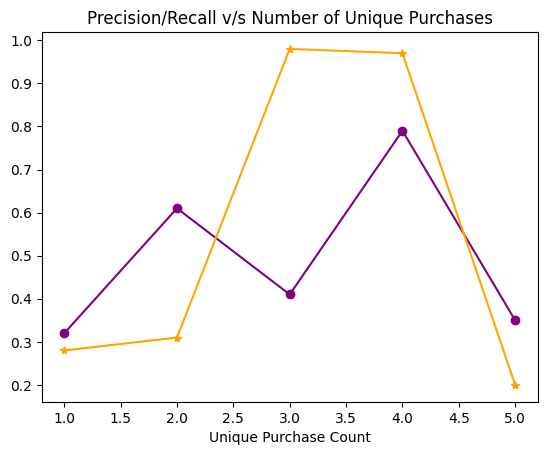

In [3]:
fig1 = plt.figure(figsize=[10,8])
ax1 = sns.distplot(user_group,bins=np.arange(7)-0.5,kde=False)
plt.yscale('log')
plt.xticks(range(0,6,1))
plt.ylabel('No. of Customers (Log Scale)',fontsize=17, weight='bold')
plt.xlabel('Total Unique Purchases', fontsize=17, weight='bold')
ax2 = plt.twinx()
sns.lineplot(x='No. of Purchase',y='Score',data=user_purchase2, hue='Metric',ax=ax2,marker='o',sort=False,palette='magma')
plt.ylim([0,1.1])
plt.ylabel('Recall/Precision Score',fontsize=17,weight='bold') 
plt.title('Purchases and Recall/Precision of Test Set',weight='bold',fontsize=20)
plt.savefig('mixplot.png',transparent=True, bbox_inches='tight')



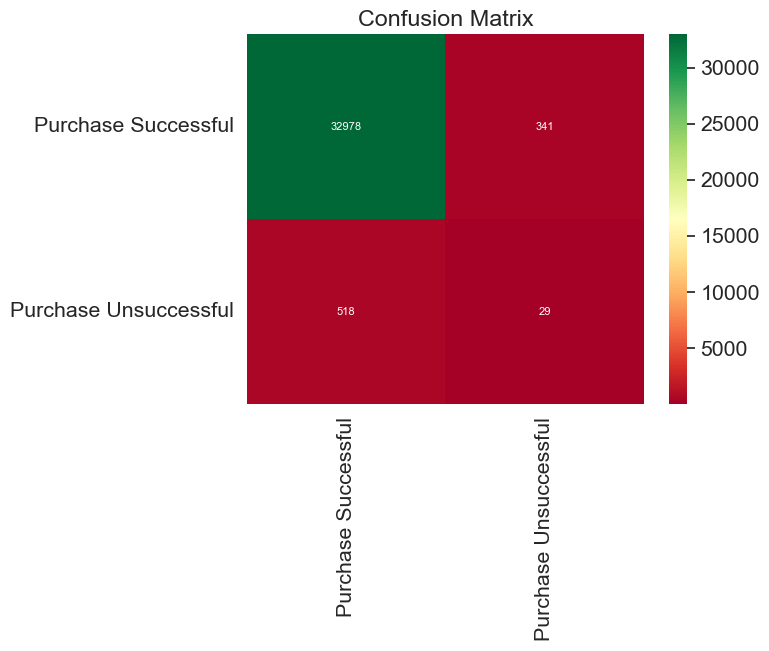

In [6]:
from matplotlib.colors import LogNorm
satisfaction_confusion = confusion_matrix(X_test['user_purchase'], X_test['predicted_purchase'])
plt.figure(dpi=120)
ax = sns.heatmap(satisfaction_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',norm=LogNorm(),
xticklabels=['Did Not Purchase', 'Purchase'],
yticklabels=['Did Not Purchase', 'Purchase']);   
plt.xlabel('Prediction',weight='bold',fontsize=12)
plt.ylabel('Actual',weight='bold',fontsize=12)
plt.title('Confusion Matrix',weight='bold',fontsize=15)
plt.savefig('confusionmatrix.png',transparent=True, bbox_inches='tight')


In [ ]:
group.to_csv('groupdf.csv')